In [ ]:
[개요]
X-Ray 사진 판독 폐렴 진단기

In [ ]:
[목차]
1. CNN 기반 베이스 모델
2. augmentation 기법 사용
3. ResNet-18 구현
4-1. 모델 구조 변경(Learning Rate 낮추기 & 콜백 적용)
4-2. 모델 구조 변경(BATCH SIZE와 EPOHCS 늘리기)

In [ ]:
1. CNN 기반 베이스 모델

In [2]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

#양성 음성 데이터 개수
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])

#tf.data 인스턴스 만들기
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

#트레이닝 데이터, 검증 데이터 개수
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()

# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"

# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)


test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)


def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds


train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)



4185
1047


In [3]:
#CNN 모델링

def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block


def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block


def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

#데이터 imbalence 처리
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

# 모델 훈련
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
    
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )


Epoch 1/10
261/261 [==============================] - 71s 212ms/step - loss: 0.3581 - accuracy: 0.8355 - precision: 0.9573 - recall: 0.8153 - val_loss: 0.7133 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 54s 208ms/step - loss: 0.2157 - accuracy: 0.9148 - precision: 0.9752 - recall: 0.9087 - val_loss: 1.1181 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 55s 211ms/step - loss: 0.1826 - accuracy: 0.9306 - precision: 0.9766 - recall: 0.9288 - val_loss: 0.1197 - val_accuracy: 0.9587 - val_precision: 0.9488 - val_recall: 0.9974
Epoch 4/10
261/261 [==============================] - 55s 213ms/step - loss: 0.1650 - accuracy: 0.9409 - precision: 0.9819 - recall: 0.9380 - val_loss: 0.2331 - val_accuracy: 0.8952 - val_precision: 0.8751 - val_recall: 1.0000
Epoch 5/10
261/261 [==============================] - 56s 215ms/step - loss: 0.1702 - accura

39/39 [==============================] - 5s 119ms/step - loss: 0.5819 - accuracy: 0.8301 - precision: 0.7946 - recall: 0.9821
Loss: 0.5819479823112488,
Accuracy: 0.8301281929016113,
Precision: 0.7946057915687561,
Recall: 0.9820512533187866


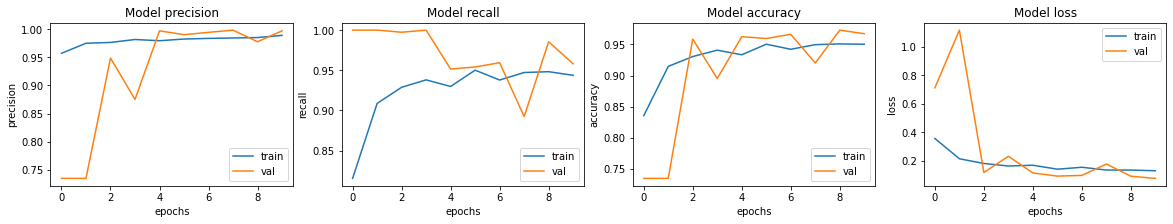

In [4]:
#결과 확인
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
    
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

In [ ]:
2. augmentation 기법 사용

In [3]:
import tensorflow as tf

def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds
#tf.data 인스턴스 만들기
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# #데이터 시각화
# def show_batch(image_batch, label_batch):
#     plt.figure(figsize=(10,10))
#     for n in range(BATCH_SIZE):
#         ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
#         plt.imshow(image_batch[n])
#         if label_batch[n]:
#             plt.title("PNEUMONIA")
#         else:
#             plt.title("NORMAL")
#         plt.axis("off")


# image_batch, label_batch = next(iter(train_ds))
# show_batch(image_batch.numpy(), label_batch.numpy())

In [2]:

#CNN 모델링

def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block


def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block


def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

#데이터 imbalence 처리
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

# 모델 훈련
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
    
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 70s 211ms/step - loss: 0.3658 - accuracy: 0.8204 - precision: 0.9609 - recall: 0.7907 - val_loss: 0.6944 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 54s 209ms/step - loss: 0.2449 - accuracy: 0.9045 - precision: 0.9708 - recall: 0.8986 - val_loss: 1.1279 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 55s 212ms/step - loss: 0.2173 - accuracy: 0.9148 - precision: 0.9718 - recall: 0.9117 - val_loss: 0.3874 - val_accuracy: 0.8279 - val_precision: 0.8110 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 56s 214ms/step - loss: 0.2015 - accuracy: 0.9219 - precision: 0.9742 - recall: 0.9197 - val_loss: 0.0931 - val_accuracy: 0.9644 - val_precision: 0.9853 - val_recall: 0.9660
Epoch 5/10
261/261 [==============================] - 57s 217ms/step - loss: 0.1715 - accura

39/39 [==============================] - 5s 115ms/step - loss: 0.3388 - accuracy: 0.8734 - precision: 0.8917 - recall: 0.9077
Loss: 0.33884522318840027,
Accuracy: 0.8733974099159241,
Precision: 0.8916876316070557,
Recall: 0.9076923131942749


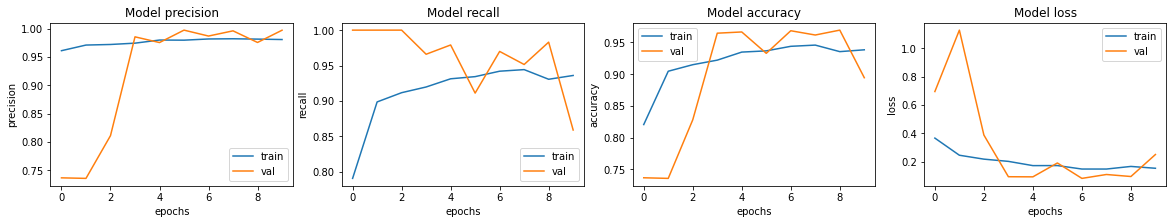

In [3]:
#결과 확인
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
    
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

In [ ]:
Accuracy와 Precision은 개선됐으나 recall 수치가 낮아짐

In [ ]:
3. ResNet-18 구현

Epoch 1/10
261/261 [==============================] - 63s 203ms/step - loss: 0.3110 - accuracy: 0.8954 - precision: 0.9603 - recall: 0.8964 - val_loss: 2.2914 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 52s 201ms/step - loss: 0.1650 - accuracy: 0.9377 - precision: 0.9807 - recall: 0.9346 - val_loss: 0.9778 - val_accuracy: 0.6125 - val_precision: 0.9973 - val_recall: 0.4745
Epoch 3/10
261/261 [==============================] - 53s 203ms/step - loss: 0.1360 - accuracy: 0.9480 - precision: 0.9839 - recall: 0.9456 - val_loss: 0.1841 - val_accuracy: 0.9298 - val_precision: 0.9986 - val_recall: 0.9060
Epoch 4/10
261/261 [==============================] - 54s 206ms/step - loss: 0.1198 - accuracy: 0.9526 - precision: 0.9853 - recall: 0.9505 - val_loss: 0.4409 - val_accuracy: 0.8202 - val_precision: 0.8036 - val_recall: 1.0000
Epoch 5/10
261/261 [==============================] - 53s 205ms/step - loss: 0.1091 - accura

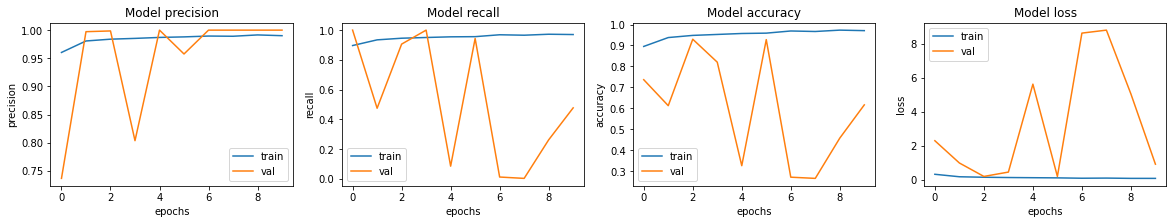

39/39 [==============================] - 5s 122ms/step - loss: 0.5424 - accuracy: 0.7500 - precision: 0.9366 - recall: 0.6436

[Model Test Evaluation]
Loss      : 0.5424
Accuracy  : 0.7500
Precision : 0.9366
Recall    : 0.6436


In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

##################################################
# 1. ResNet-18 구현
##################################################
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x

    # 첫 번째 Conv
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 두 번째 Conv
    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # Shortcut: 채널 수나 stride가 다르면 맞춰주기
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

def build_resnet18(input_shape=(180, 180, 3)):
    inputs = layers.Input(shape=input_shape)

    # 초기 Conv + MaxPooling
    x = layers.Conv2D(64, 7, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # ResNet-18의 4개 스테이지
    filters = [64, 128, 256, 512]
    strides = [1, 2, 2, 2]  # 각 스테이지 첫 블록에서 stride 적용

    for i in range(4):
        x = residual_block(x, filters[i], stride=strides[i])
        x = residual_block(x, filters[i])

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)
    # 이진 분류(sigmoid)
    x = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, x)
    return model

##################################################
# 2. 모델 컴파일 & 학습
##################################################
# 예: class_weight 계산 (이미 COUNT_NORMAL, COUNT_PNEUMONIA를 구했다고 가정)
total = COUNT_NORMAL + COUNT_PNEUMONIA
weight_for_0 = (1 / COUNT_NORMAL) * (total / 2.0)  # NORMAL(0)에 대한 가중치
weight_for_1 = (1 / COUNT_PNEUMONIA) * (total / 2.0)  # PNEUMONIA(1)에 대한 가중치

class_weight = {0: weight_for_0, 1: weight_for_1}

with tf.device('/GPU:0'):
    model = build_resnet18()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

##################################################
# 3. 학습 결과 시각화 & 최종 평가
##################################################
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

# 확인하고 싶은 지표 리스트
metrics_list = ['precision', 'recall', 'accuracy', 'loss']

for i, met in enumerate(metrics_list):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title(f'Model {met}')
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

plt.show()

# 테스트 세트 최종 평가
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'\n[Model Test Evaluation]')
print(f'Loss      : {loss:.4f}')
print(f'Accuracy  : {accuracy:.4f}')
print(f'Precision : {precision:.4f}')
print(f'Recall    : {recall:.4f}')


In [ ]:
ResNet-18 모델로 학습시킨 결과 학습 성능이 매우 낮은 결과를 얻음

In [ ]:
4. 모델 구조 변경(Learning Rate 낮추기 & 콜백 적용, Batch size, Epochs 늘리기)

Epoch 1/15
130/130 [==============================] - 48s 252ms/step - loss: 0.2516 - accuracy: 0.8923 - precision: 0.9674 - recall: 0.8845 - val_loss: 1.3050 - val_accuracy: 0.7246 - val_precision: 0.7246 - val_recall: 1.0000
Epoch 2/15
130/130 [==============================] - 31s 244ms/step - loss: 0.1700 - accuracy: 0.9375 - precision: 0.9759 - recall: 0.9394 - val_loss: 2.3035 - val_accuracy: 0.7246 - val_precision: 0.7246 - val_recall: 1.0000
Epoch 3/15
130/130 [==============================] - 32s 251ms/step - loss: 0.1317 - accuracy: 0.9466 - precision: 0.9807 - recall: 0.9473 - val_loss: 0.7901 - val_accuracy: 0.7441 - val_precision: 0.7441 - val_recall: 1.0000
Epoch 4/15
130/130 [==============================] - 32s 247ms/step - loss: 0.1234 - accuracy: 0.9543 - precision: 0.9840 - recall: 0.9542 - val_loss: 0.6932 - val_accuracy: 0.7344 - val_precision: 0.7318 - val_recall: 1.0000
Epoch 5/15
130/130 [==============================] - 34s 261ms/step - loss: 0.0797 - accura

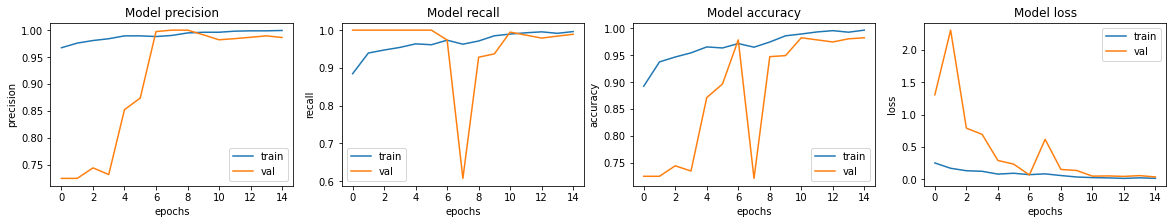

39/39 [==============================] - 5s 126ms/step - loss: 1.0708 - accuracy: 0.7708 - precision: 0.7343 - recall: 0.9923

[Model Test Evaluation]
Loss      : 1.0708
Accuracy  : 0.7708
Precision : 0.7343
Recall    : 0.9923


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt


def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x

    # 첫 번째 Conv
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 두 번째 Conv
    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # Shortcut: 채널 수나 stride가 다르면 맞춰주기
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

def build_resnet18(input_shape=(180, 180, 3)):
    inputs = layers.Input(shape=input_shape)

    # 초기 Conv + MaxPooling
    x = layers.Conv2D(64, 7, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # ResNet-18의 4개 스테이지
    filters = [64, 128, 256, 512]
    strides = [1, 2, 2, 2]  # 각 스테이지 첫 블록에서 stride 적용

    for i in range(4):
        x = residual_block(x, filters[i], stride=strides[i])
        x = residual_block(x, filters[i])

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)
    # 이진 분류(sigmoid)
    x = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, x)
    return model


import tensorflow as tf
tf.keras.backend.clear_session()

import matplotlib.pyplot as plt

BATCH_SIZE = 32
EPOCHS = 15

# Adam 옵티마이저에 원하는 학습률 설정
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model = build_resnet18(input_shape=(180, 180, 3))
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=METRICS
)

# 콜백: EarlyStopping, ReduceLROnPlateau
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',   # 모니터링 대상
    patience=7,           # 개선 없는 epoch 수
    restore_best_weights=True
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,    # lr 1/10으로 줄이기
    patience=3,    # 3 epoch 동안 개선 없으면 lr 감소
    verbose=1
)

# class_weight 예시
total = COUNT_NORMAL + COUNT_PNEUMONIA
weight_for_0 = (1 / COUNT_NORMAL) * (total / 2.0)
weight_for_1 = (1 / COUNT_PNEUMONIA) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}

# GPU에서 학습
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        epochs=EPOCHS,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[early_stopping, reduce_lr]
    )

# 결과 시각화
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
plt.show()

# 테스트 세트 평가
loss, accuracy, precision, recall = model.evaluate(test_ds)
print('\n[Model Test Evaluation]')
print(f'Loss      : {loss:.4f}')
print(f'Accuracy  : {accuracy:.4f}')
print(f'Precision : {precision:.4f}')
print(f'Recall    : {recall:.4f}')


In [ ]:
Recall 최대치 달성

In [ ]:
[summary 및 회고]
1. CNN 기반 베이스 모델 학습 결과
Loss: 0.5819479823112488,
Accuracy: 0.8301281929016113,
Precision: 0.7946057915687561,
Recall: 0.9820512533187866
    
2. 데이터 augmentation 이후 CNN 모델 학습 결과
Loss: 0.33884522318840027,
Accuracy: 0.8733974099159241,
Precision: 0.8916876316070557,
Recall: 0.9076923131942749
    loss 감소, accuracy, precision 증가, recall 감소
    recall을 제외한 나머지 성능 상승
    의료 데이터이므로 recall 성능도 중요함

3. ResNet-18 모델로 학습
Loss      : 0.5424
Accuracy  : 0.7500
Precision : 0.9366
Recall    : 0.6436
    전반적으로 성능이 저하됨

4. 모델 구조 변경
Loss      : 1.0708
Accuracy  : 0.7708
Precision : 0.7343
Recall    : 0.9923
    recall 최대치 달성